## STA 160

## Final Project: 

In [13]:
# Import Libraries
import pandas as pd
import numpy as np

import requests
import json
import datetime as dt
import itertools
from itertools import repeat

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

from sklearn.model_selection import KFold

In [14]:
%run ../code/weather_scraper.py
el_dorado_df = weather_to_df(fips_code="06017",county = "El Dorado")
imperial_df = weather_to_df(fips_code="06025",county = "Imperial")
mendocino_df = weather_to_df(fips_code="06045",county = "Mendocino")
riverside_df = weather_to_df(fips_code="06065",county = "Riverside")
siskiyou_df = weather_to_df(fips_code="06093",county = "Siskiyou")
solano_df = weather_to_df(fips_code="06095",county = "Solano")

## Our Data:

Weather Data:
- stored in object: df_weather
- Rows: 15 minute interval in a given day. (96 rows per day)
- Columns: Date,tmax(temp),tmin(temp),Precip,average(temp),daily_avg_windspeed, county
- Instances:
    - dataL: Solano, FIPS = 095
    - dataS: Siskiyou, FIPS = 093
    - dataR: Riverside, FIPS = 065
    - dataM: Mendocino, FIPS = 045
    - dataI: Imperial, FIPS = 025
    - dataE: El Dorado, FIPS = 017
    
Fire Data:
- stored in object: fire_data
- Rows: a unique wildfire
- Columns: FPA_ID, FIRE_CODE, FIRE_NAME, FIRE_YEAR, date(DISCOVERY_DATE), DISCOVERY_TIME, STAT_CAUSE_CODE, STAT_CAUSE_DESCR, date(CONT_DATE), FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, FIPS_CODE,FIPS_NAME,STATE.

## Next Step:

- Segment fire data by fire_class. 
    - Note: fire_classes are imbalanced. We randomly subset 15 observations within larger fire classes. (15 samples in the smallest fire class.)
- Investigate weather conditions of discovery date +- 7 days of each instance per fire_class. 
    - Hierarchical clustering of avg_temp, precip, avg_windspeed of all 5*45 observations for each day within the 14 day range. 
        - i.e. See if fires of the same fire class have similar structures for t-72 hours before discovery
        - Maybe identify fires that are started by arson.
        - 
- K-means clustering of geospatial data for 2 week intervals to identify trends in fire location.   


In [59]:
# scrape merced data
dataL = pd.DataFrame()
new = []

date = ["03", "06", "07", "10"]

for d in date:
    start = "01-01-20" +d
    end = "12-31-20" +d
    dates = pd.date_range(start=start, end=end, freq = 'Y')
    dates = dates.strftime("%Y")   
    dates = dates.to_list()        
    
    Token = 'eLCmbnPGUBzvYdVYFMZYpulbSoXjYkfX'

    date_rain = []
    date_tmax = []
    date_tmin = []
    rain_lst = []
    tmin_lst = []
    tmax_lst = []

    #query API for data of interest:
    for i in dates: #loop through list of years and append them to API call where appropriate
        temp_max = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&limit=1000&locationid=FIPS:06047&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})
        rain = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=PRCP&limit=1000&locationid=FIPS:06047&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})
        temp_min = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMIN&limit=1000&locationid=FIPS:06047&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})

        #convert to JSON:
        rain = rain.json()
        tmin = temp_min.json()
        tmax = temp_max.json()

        #create dataframe for each API call:
        rain_table = pd.json_normalize(rain["results"])
        tmin_table = pd.json_normalize(tmin["results"])
        tmax_table = pd.json_normalize(tmax["results"])

        #append data to appropriate list in order to construct overall dataset for Solano:
        date_rain.append(rain_table["date"].tolist())
        rain_lst.append(rain_table["value"].tolist())
        date_tmin.append(tmin_table['date'].tolist())
        tmin_lst.append(tmin_table['value'].tolist())
        date_tmax.append(tmax_table['date'].tolist())
        tmax_lst.append(tmax_table['value'].tolist())

    #create dataset with date and value for each paramter of interest:
    rain_data = pd.DataFrame({
        "Date":list(itertools.chain.from_iterable(date_rain)),
        "Precip":list(itertools.chain.from_iterable(rain_lst))})

    tmax_data = pd.DataFrame({
        "Date":list(itertools.chain.from_iterable(date_tmax)),
        "tmax":list(itertools.chain.from_iterable(tmax_lst))})

    tmin_data = pd.DataFrame({
        "Date": list(itertools.chain.from_iterable(date_tmin)),
        "tmin":list(itertools.chain.from_iterable(tmin_lst))})
    
    #set indices:
    rain_data = rain_data.set_index("Date")
    tmax_data = tmax_data.set_index("Date")
    tmin_data = tmin_data.set_index("Date")
    
    #clean dates and set indices for merge:

    #clean date variable:
    rain_data.index = pd.to_datetime(rain_data.index)
    tmax_data.index = pd.to_datetime(tmax_data.index)
    tmin_data.index = pd.to_datetime(tmin_data.index)

    #merge datasets into 1 dataset:
    merced_dat = tmax_data.merge(tmin_data, how = "left",left_index=True, right_index=True)
    merced_dat = merced_dat.merge(rain_data, how = "inner",left_index=True, right_index=True)
    merced_dat["average"] = merced_dat["tmin"]+((merced_dat["tmax"]-merced_dat["tmin"])/2) #compute average temperature
    merced_dat = merced_dat.dropna()
    
    #append into one dataframe
    new.append(merced_dat)

#show dataset:
dataZ = pd.concat(new)
print(dataZ)
dataZ.to_csv('dataZ.csv')

            tmax  tmin  Precip  average
Date                                   
2003-01-01  57.0  34.0    0.00     45.5
2003-01-01  57.0  34.0    0.02     45.5
2003-01-01  57.0  34.0    0.00     45.5
2003-01-01  57.0  34.0    0.03     45.5
2003-01-01  57.0  34.0    0.00     45.5
...          ...   ...     ...      ...
2010-05-25  75.0  43.0    0.01     59.0
2010-05-25  75.0  43.0    0.00     59.0
2010-05-25  75.0  43.0    0.00     59.0
2010-05-25  75.0  43.0    0.13     59.0
2010-05-25  75.0  43.0    0.12     59.0

[234812 rows x 4 columns]


In [6]:
# import temp and precipitation data:

dataE = pd.read_csv('../data/dataE.csv') # El Dorado
dataE['FIPS_NAME'] = 'El Dorado'

dataI = pd.read_csv('../data/dataI.csv') # Imperial
dataI['FIPS_NAME'] = 'Imperial'

dataZ = pd.read_csv('../data/dataZ.csv') # Merced
dataZ['FIPS_NAME'] = 'Merced'

dataM = pd.read_csv('../data/dataM.csv') # Mendocino
dataM['FIPS_NAME'] = 'Mendocino'

dataR = pd.read_csv('../data/dataR.csv') # Riverside
dataR['FIPS_NAME'] = 'Riverside'

dataS = pd.read_csv('../data/dataS.csv') # Siskyou
dataS['FIPS_NAME'] = 'Siskyou'

all_temp_precip = pd.concat([dataE,dataI,dataZ,dataM,dataR,dataS])
all_temp_precip['Date'] = pd.to_datetime(all_temp_precip['Date'])
all_temp_precip = all_temp_precip.drop_duplicates(subset=['Date','FIPS_NAME'],keep='first')
all_temp_precip = all_temp_precip.reset_index()
all_temp_precip.drop("index", axis=1, inplace=True)
all_temp_precip

,Date,tmax,tmin,Precip,average,FIPS_NAME
0,2003-01-01,50.0,42.0,0.00,46.0,El Dorado
1,2003-01-02,44.0,29.0,0.00,36.5,El Dorado
2,2003-01-03,53.0,31.0,0.00,42.0,El Dorado
3,2003-01-04,64.0,42.0,0.00,53.0,El Dorado
4,2003-01-05,69.0,44.0,0.00,56.5,El Dorado
...,...,...,...,...,...,...
1753,2010-02-05,50.0,30.0,0.19,40.0,Siskyou
1754,2010-02-06,51.0,38.0,0.01,44.5,Siskyou
1755,2010-02-07,50.0,35.0,0.01,42.5,Siskyou
1756,2010-02-08,48.0,27.0,0.00,37.5,Siskyou


In [7]:
# import wind data:
imperial_wind = pd.read_csv('../data/Imperial_county_wind_data.csv')
imperial_wind['FIPS_NAME'] = 'Imperial'

merced_wind = pd.read_csv('../data/Merced_county_wind_data.csv')
merced_wind['FIPS_NAME'] = 'Merced'

mendocino_wind = pd.read_csv('../data/Mendocino_county_wind_data.csv')
mendocino_wind['FIPS_NAME'] = 'Mendocino'

riverside_wind = pd.read_csv('../data/Riverside_county_wind_data.csv')
riverside_wind['FIPS_NAME'] = 'Riverside'

siskyou_wind = pd.read_csv('../data/Siskyou_county_wind_data.csv')
siskyou_wind['FIPS_NAME'] = 'Siskyou'

eldorado_wind = pd.read_csv('../data/el_dorado_county_wind_data.csv')
eldorado_wind['FIPS_NAME'] = 'El Dorado'

all_wind = pd.concat([imperial_wind,merced_wind,riverside_wind,siskyou_wind,eldorado_wind])
all_wind['Date'] = pd.to_datetime(all_wind['Date'])
all_wind = all_wind.reset_index()
all_wind.drop("index", axis=1, inplace=True)
all_wind

,Date,wind_speed,FIPS_NAME
0,2003-01-01,5.6,Imperial
1,2003-01-02,5.6,Imperial
2,2003-01-03,3.8,Imperial
3,2003-01-03,3.1,Imperial
4,2003-01-04,3.1,Imperial
...,...,...,...
12148,2010-12-24,1.6,El Dorado
12149,2010-12-25,13.9,El Dorado
12150,2010-12-26,9.8,El Dorado
12151,2010-12-27,2.9,El Dorado


In [9]:
joined_weather = pd.read_csv("../data/joined_weather.csv")
joined_weather.drop("Unnamed: 0", axis=1, inplace=True)
joined_weather.drop("index", axis=1, inplace=True)
joined_weather['Date'] = pd.to_datetime(joined_weather['Date'])
joined_weather

,Date,county,tmax_left,tmin_left,Precip_right,average_left,wind_speed
0,2003-01-01,El Dorado,50.0,42.0,0.080000,46.0,2.7
1,2003-01-01,Imperial,70.0,37.0,0.000000,53.5,5.6
2,2003-01-01,Mendocino,46.0,32.0,0.000000,39.0,0.7
3,2003-01-01,Merced,57.0,34.0,0.008333,45.5,1.8
4,2003-01-01,Siskyou,45.0,28.0,0.008333,36.5,0.7
...,...,...,...,...,...,...,...
2329,2010-05-21,Merced,78.0,56.0,0.000000,67.0,12.3
2330,2010-05-22,Merced,71.0,51.0,0.000000,61.0,9.4
2331,2010-05-23,Merced,66.0,51.0,0.000000,58.5,10.7
2332,2010-05-24,Merced,73.0,56.0,0.000000,64.5,5.4


In [10]:
dendro_subset = joined_weather[['Precip_right','average_left','wind_speed']]
dendro_subset = dendro_subset.rename(columns={"Precip_right": "precipitation", "average_left": "average_temp"})
dendro_subset = dendro_subset.dropna()
dendro_subset = dendro_subset.reset_index()
dendro_subset.drop("index", axis=1, inplace=True)
dendro_subset

,precipitation,average_temp,wind_speed
0,0.080000,46.0,2.7
1,0.000000,53.5,5.6
2,0.000000,39.0,0.7
3,0.008333,45.5,1.8
4,0.008333,36.5,0.7
...,...,...,...
2323,0.000000,67.0,12.3
2324,0.000000,61.0,9.4
2325,0.000000,58.5,10.7
2326,0.000000,64.5,5.4


In [14]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

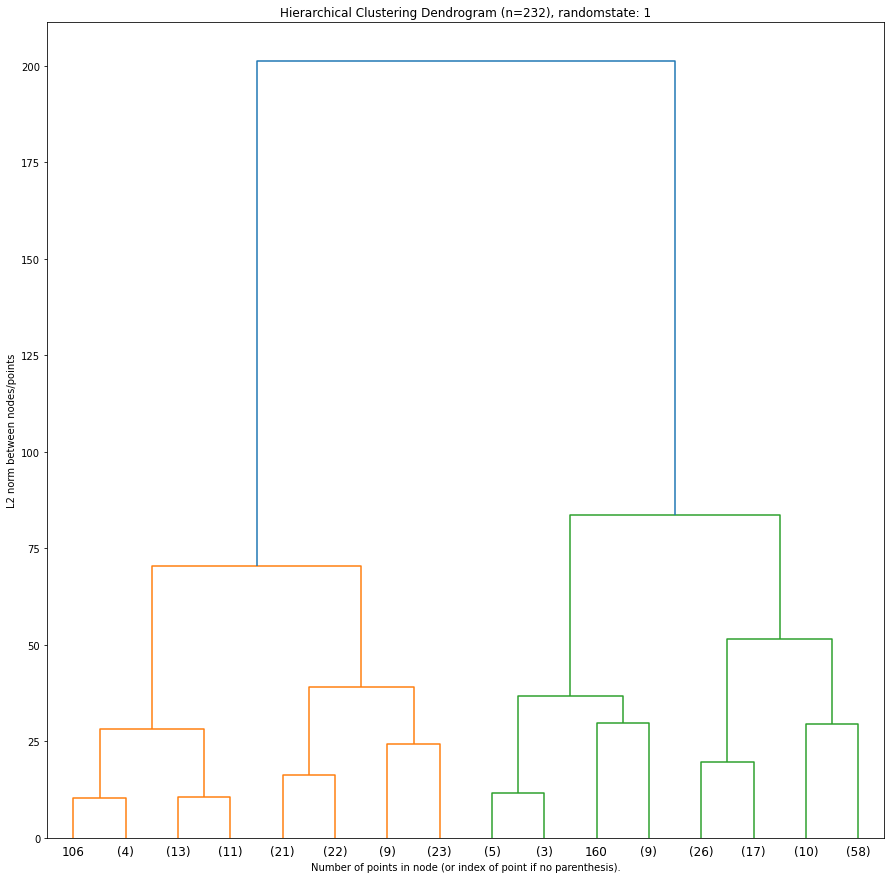

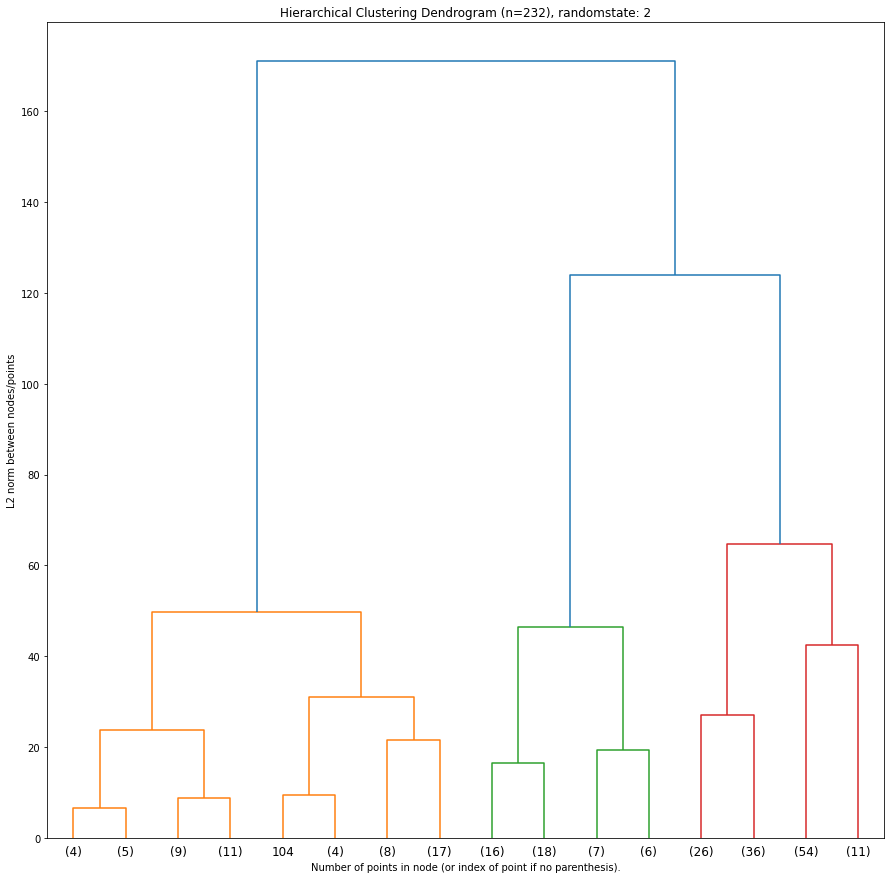

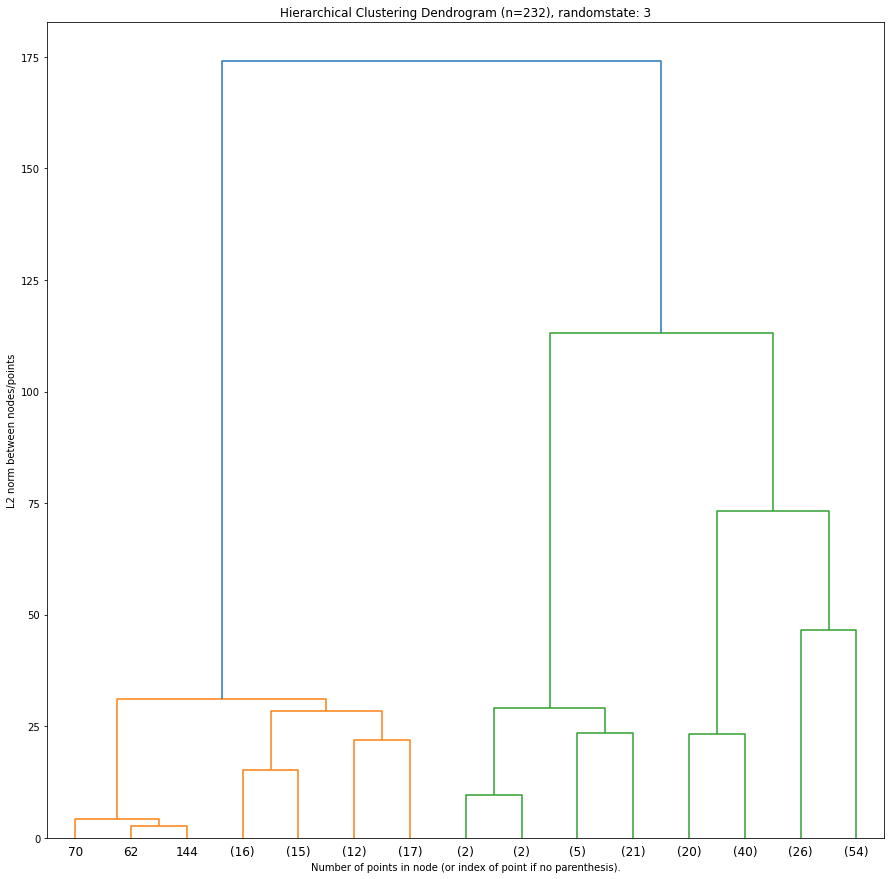

In [15]:
# dendrogram of random subsets with 232 obs each

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

dendro_array = dendro_subset.to_numpy()

fold = 0
kf = KFold(n_splits = 10, random_state = True, shuffle = True)
plt.rcParams["figure.figsize"] = (15,15)
for train_index, test_index in kf.split(dendro_array):
    fold+=1
    temp_X = dendro_array[test_index] 
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(temp_X)
    plt.title("Hierarchical Clustering Dendrogram (n=232), randomstate: %d" %fold)
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode="level", p=3)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.ylabel("L2 norm between nodes/points")
    plt.show()
    if fold ==3:
        break

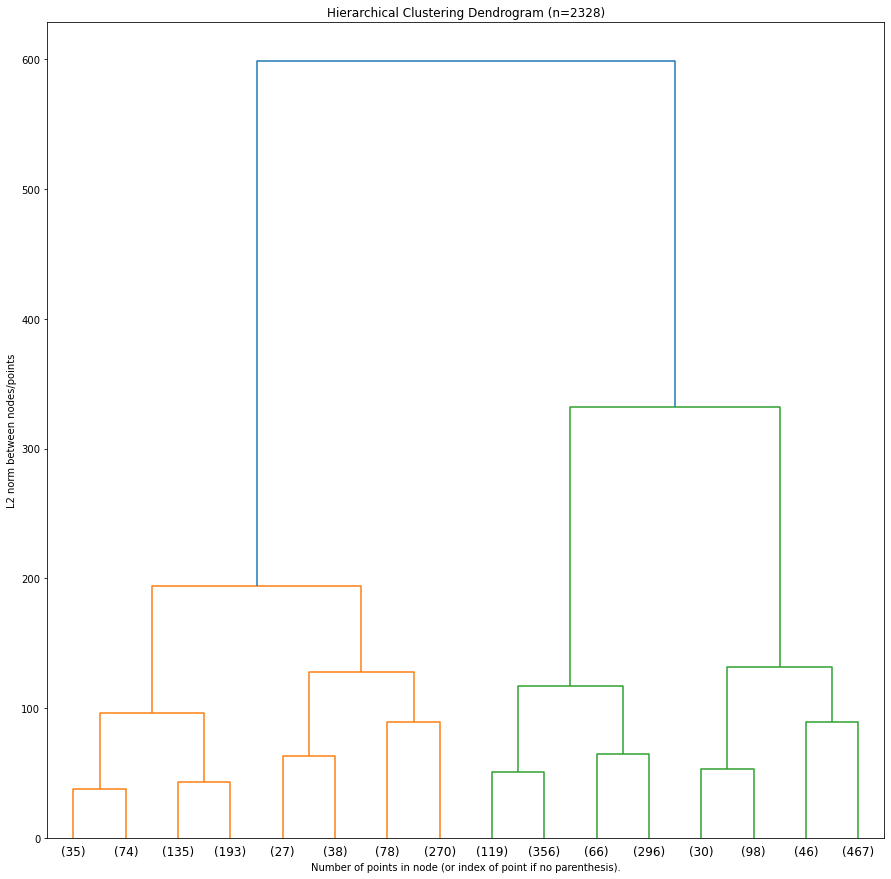

In [16]:
# dendrogram of all 2328 obs

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(dendro_array)
plt.title("Hierarchical Clustering Dendrogram (n=2328)")

plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

## Investigating weather patterns of every day within one week of fire discovery.
* Based on minimum temperature, maximum temperature, Average temperature, Precipitation, Wind speed

### Interpretation
* 
* Leading up to the fire discovery 
* 

In [67]:
# Fires that we will investigate

fire_db = pd.read_csv('../data/weather_fire.csv')
fire_db.drop_duplicates(subset ="FIRE_NAME", keep = False, inplace = True)
fire_db = fire_db[["FIPS_NAME","Date","FIRE_SIZE_CLASS"]]
fire_db['Date'] = pd.to_datetime(fire_db['Date'])
fire_db = fire_db.dropna()
fire_db = fire_db.reset_index()
fire_db.drop("index", axis=1, inplace=True)
fire_db

,FIPS_NAME,Date,FIRE_SIZE_CLASS
0,El Dorado,2003-02-10,A
1,El Dorado,2003-03-10,A
2,El Dorado,2006-02-25,A
3,El Dorado,2006-02-26,A
4,El Dorado,2007-01-03,B
5,El Dorado,2007-01-14,B
6,El Dorado,2007-01-15,B
7,Merced,2007-01-20,A
8,El Dorado,2007-01-20,A
9,El Dorado,2007-01-21,B


In [113]:
# dendrograms for each day within 1 week of discovery date. Aim: to identify if fire classes have different weather condition in days leading up to and after discovery date

# subset weather data 
minus_7_weather,minus_6_weather,minus_5_weather,minus_4_weather,minus_3_weather,minus_2_weather,minus_1_weather,day_of_weather,plus_1_weather,plus_2_weather,plus_3_weather,plus_4_weather,plus_5_weather,plus_6_weather,plus_7_weather = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[]

for i in range(len(fire_db)):
    minus_7_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] - dt.timedelta(days=7))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    minus_6_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] - dt.timedelta(days=6))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    minus_5_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] - dt.timedelta(days=5))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    minus_4_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] - dt.timedelta(days=4))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    minus_3_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] - dt.timedelta(days=3))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    minus_2_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] - dt.timedelta(days=2))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    minus_1_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] - dt.timedelta(days=1))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    day_of_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i])) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    plus_1_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] + dt.timedelta(days=1))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    plus_2_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] + dt.timedelta(days=2))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    plus_3_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] + dt.timedelta(days=3))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    plus_4_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] + dt.timedelta(days=4))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    plus_5_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] + dt.timedelta(days=5))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    plus_6_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] + dt.timedelta(days=6))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])
    plus_7_weather.append(joined_weather[(all_temp_precip.Date == (fire_db['Date'][i] + dt.timedelta(days=7))) & (joined_weather.county == fire_db['FIPS_NAME'][i])])

In [139]:
def list_to_df(df):
    temp = pd.DataFrame()
    for i in range(len(df)):
        temp = pd.concat([temp,df[i]])
    dendro_subset = temp[['Precip_right','average_left','wind_speed']]
    dendro_array = dendro_subset.to_numpy()
    return dendro_array

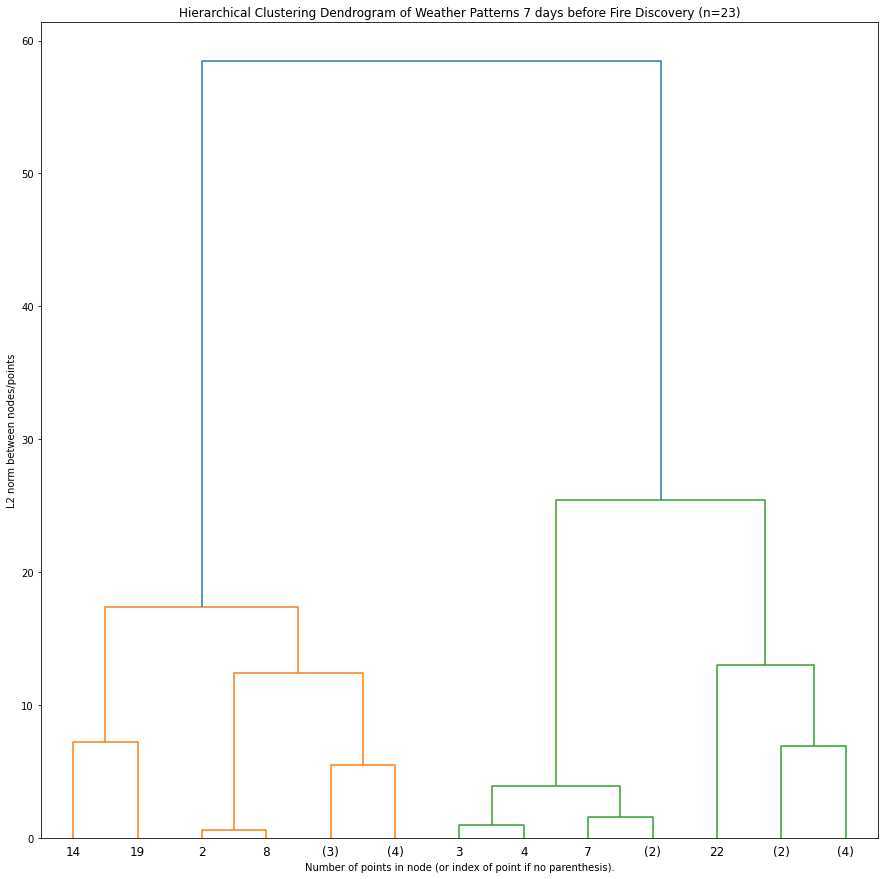

In [140]:
# Dendrogram of Weather Patterns 7 days prior to discovery 

minus_7 = list_to_df(minus_7_weather)
size = np.shape(minus_7)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(minus_7)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 7 days before Fire Discovery (n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

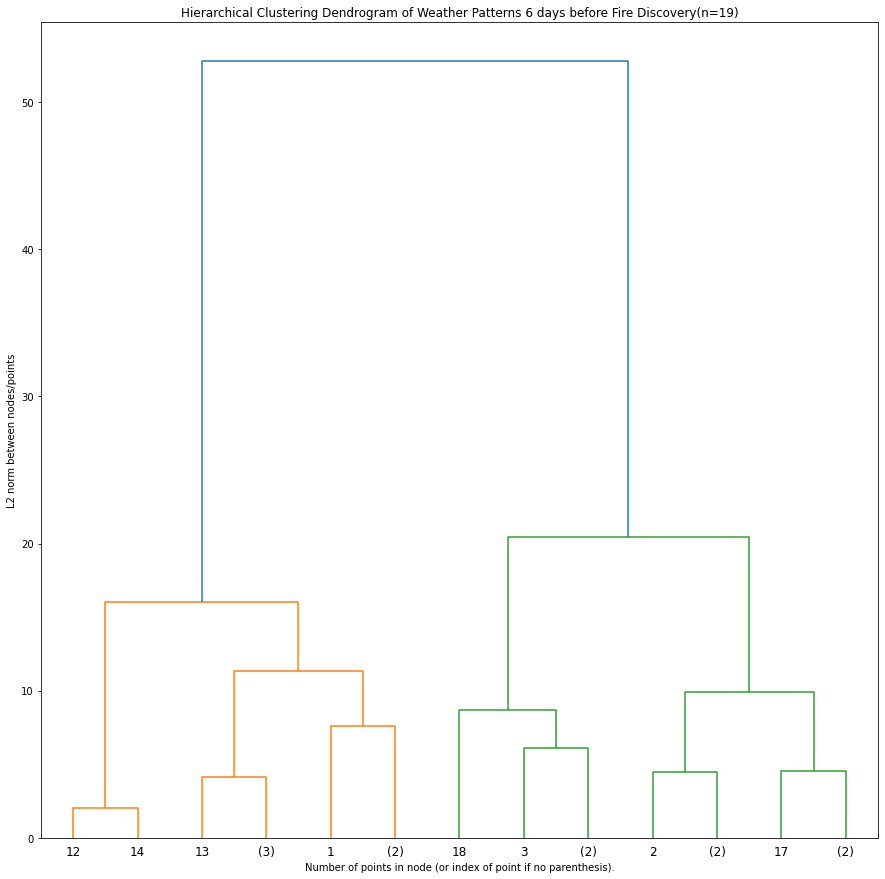

In [141]:
# Dendrogram of Weather Patterns 6 days prior to discovery 

minus_6 = list_to_df(minus_6_weather)
size = np.shape(minus_6)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(minus_6)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 6 days before Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

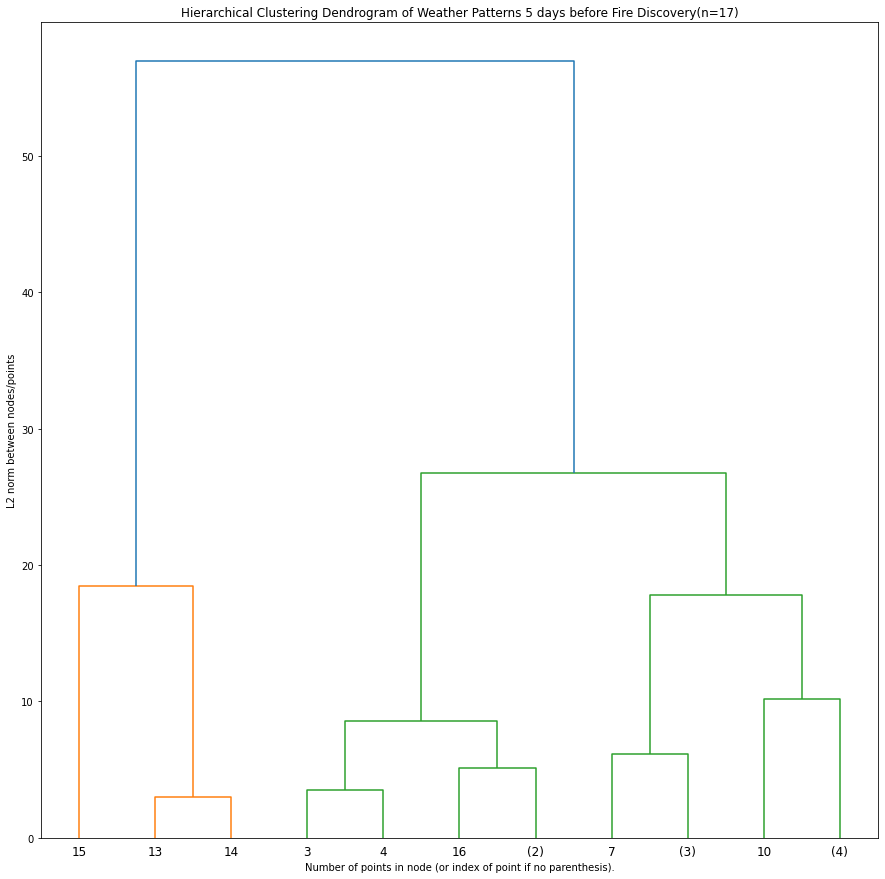

In [142]:
# Dendrogram of Weather Patterns 5 days prior to discovery 

minus_5 = list_to_df(minus_5_weather)
size = np.shape(minus_5)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(minus_5)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 5 days before Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

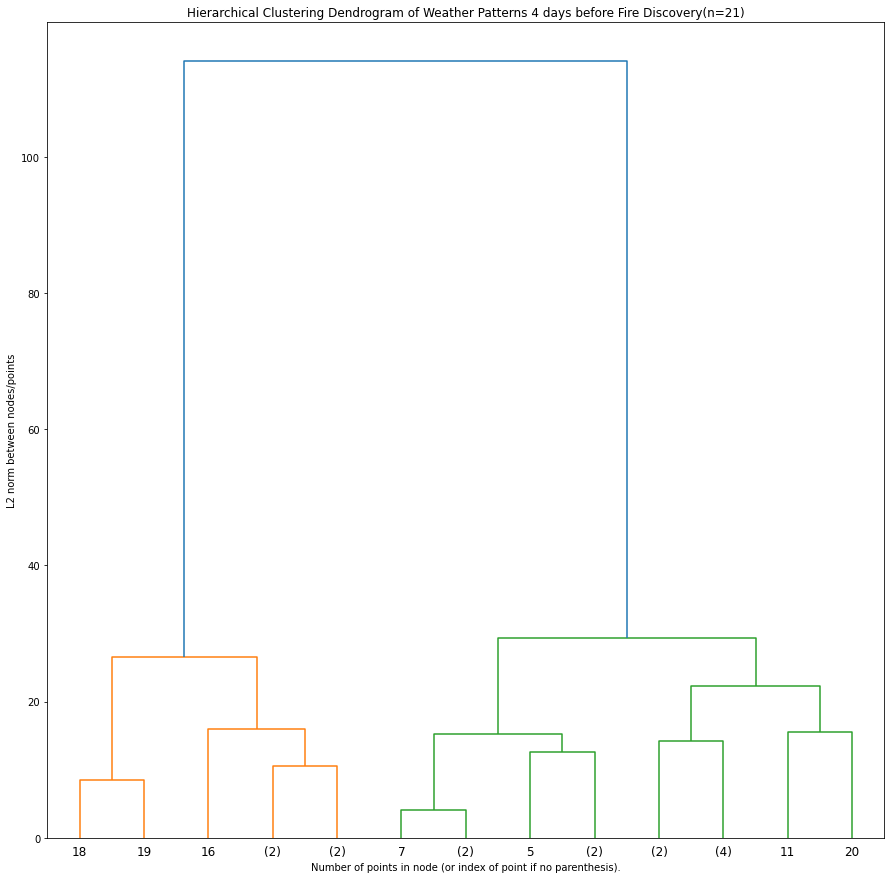

In [100]:
# Dendrogram of Weather Patterns 4 days prior to discovery 

minus_4 = list_to_df(minus_4_weather)
size = np.shape(minus_4)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(minus_4)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 4 days before Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

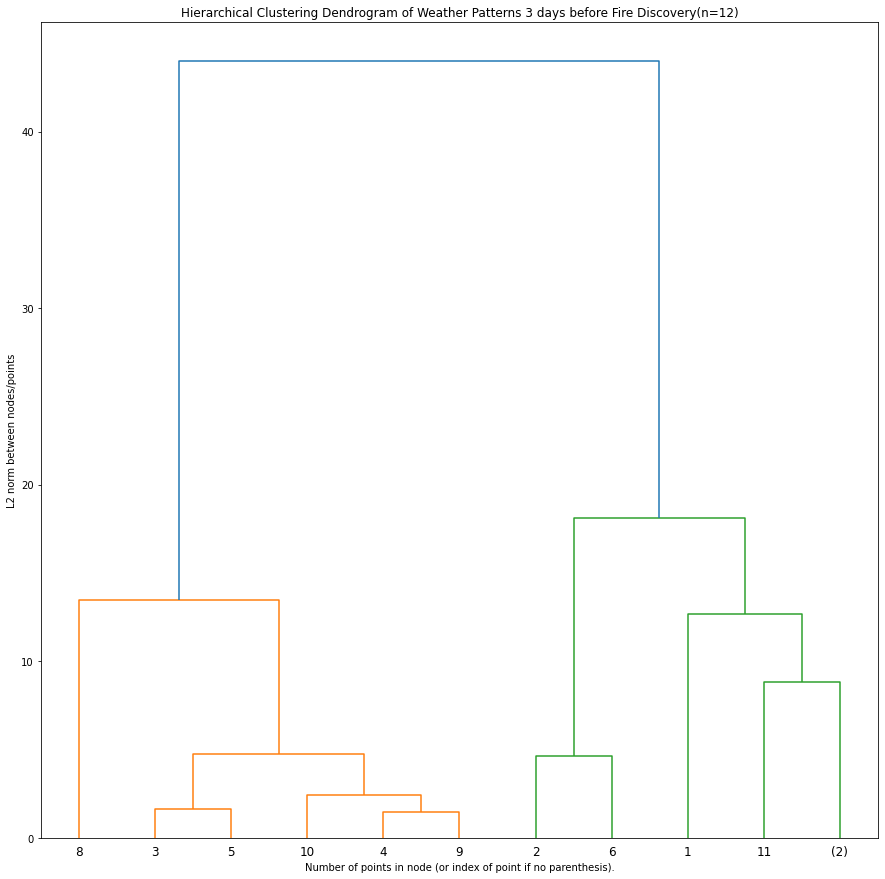

In [144]:
# Dendrogram of Weather Patterns 3 days prior to discovery 

minus_3 = list_to_df(minus_3_weather)
size = np.shape(minus_3)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(minus_3)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 3 days before Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

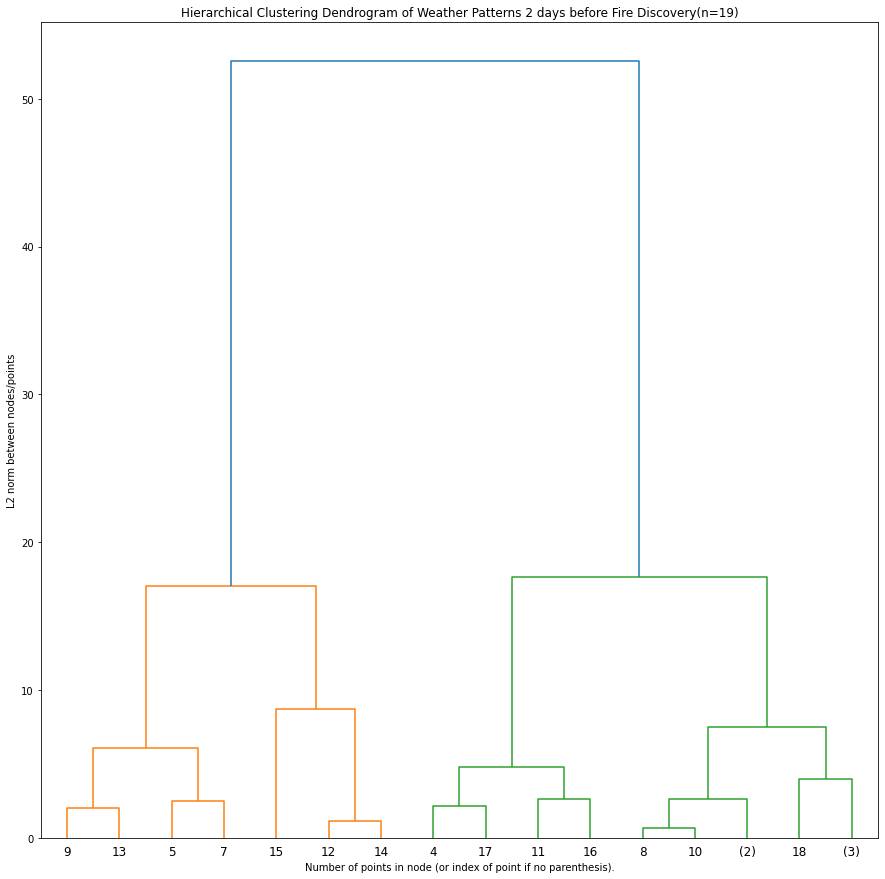

In [143]:
# Dendrogram of Weather Patterns 2 days prior to discovery 

minus_2 = list_to_df(minus_2_weather)
size = np.shape(minus_2)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(minus_2)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 2 days before Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

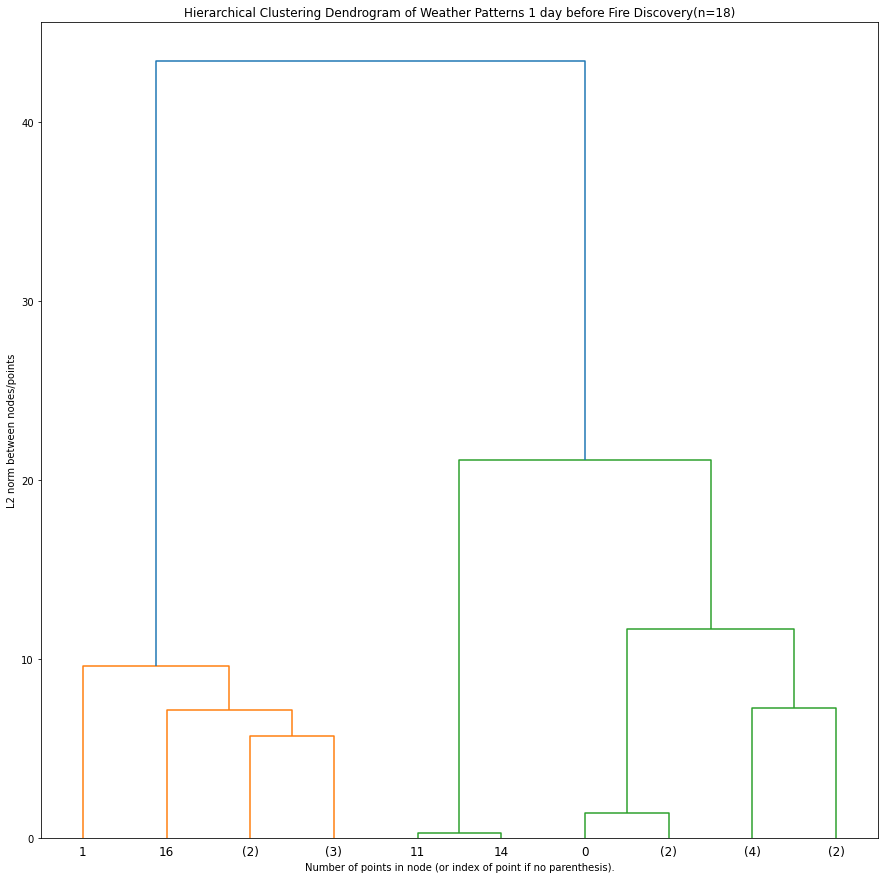

In [145]:
# Dendrogram of Weather Patterns 1 day prior to discovery 

minus_1 = list_to_df(minus_1_weather)
size = np.shape(minus_1)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(minus_1)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 1 day before Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

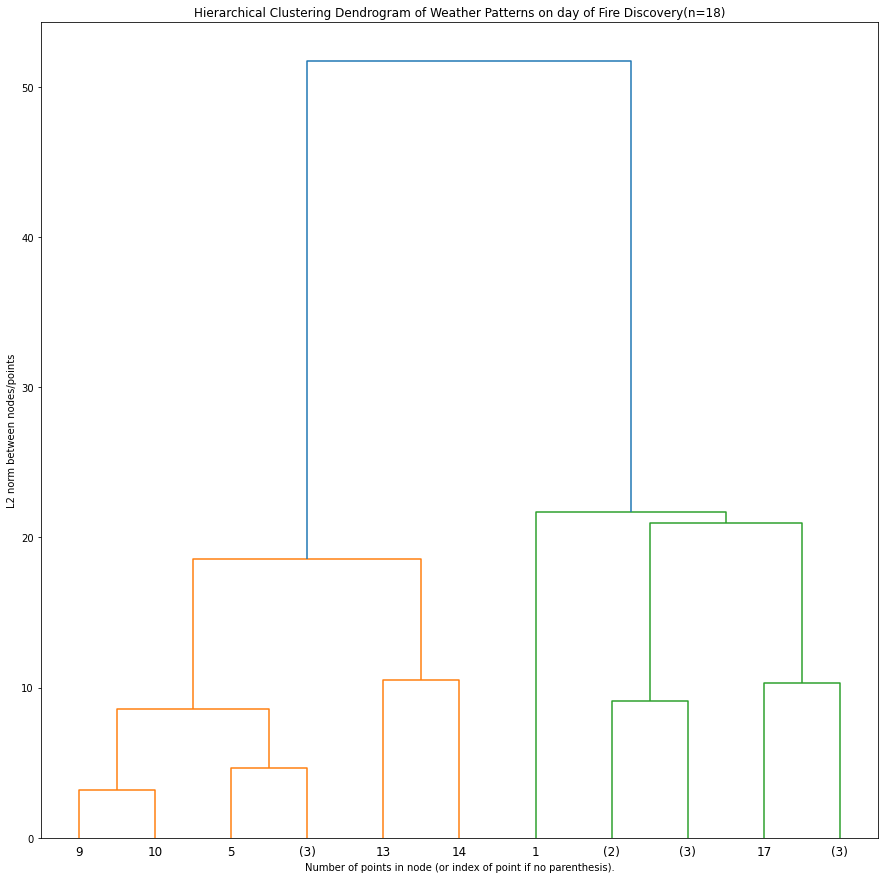

In [146]:
# Dendrogram of Weather Patterns on the day of fire discovery 

day_of = list_to_df(day_of_weather)
size = np.shape(day_of)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(day_of)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns on day of Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

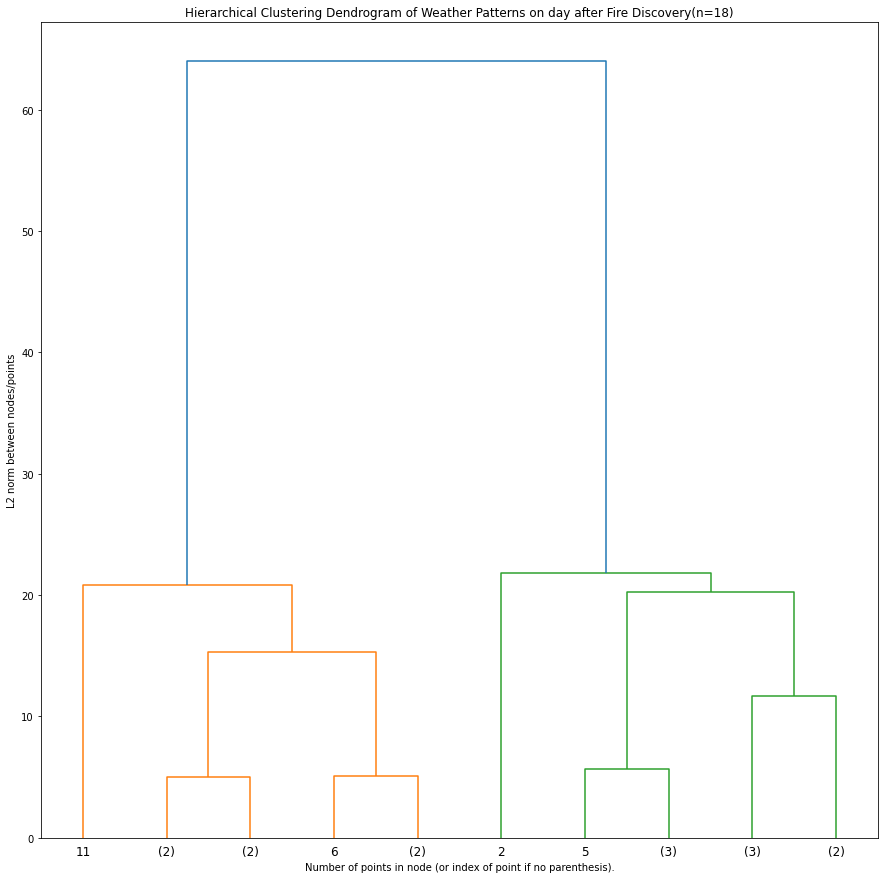

In [147]:
# Dendrogram of Weather Patterns on the day after fire discovery 

plus_1 = list_to_df(plus_1_weather)
size = np.shape(plus_1)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(plus_1)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns on day after Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

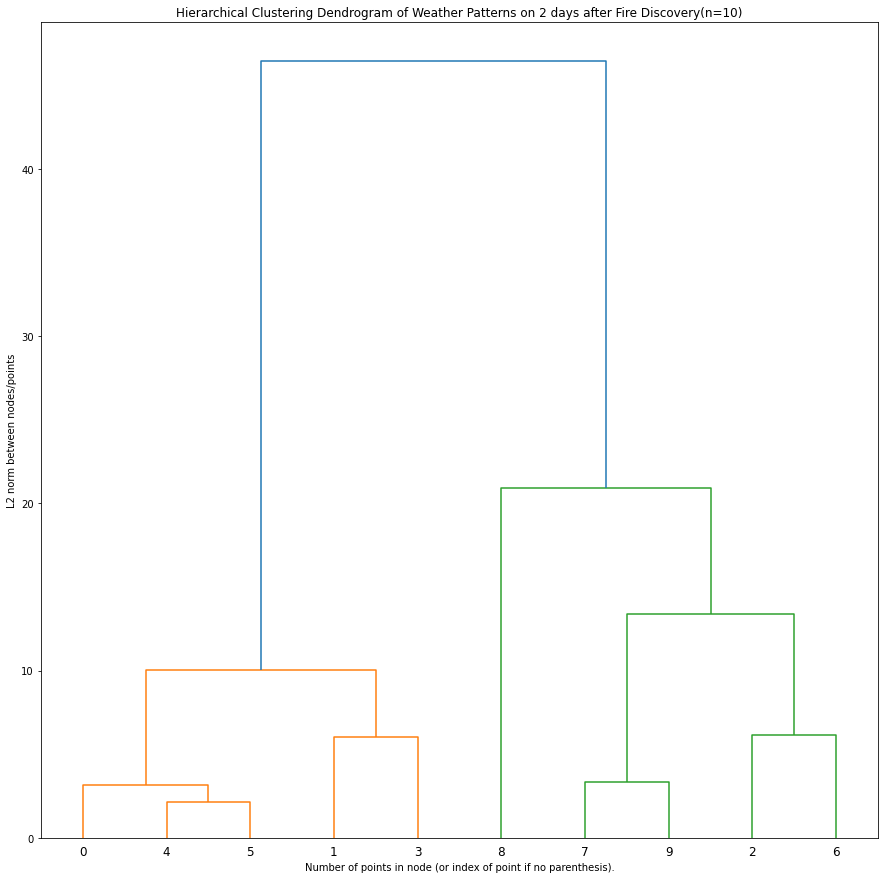

In [148]:
# Dendrogram of Weather Patterns on the day after fire discovery 

plus_2 = list_to_df(plus_2_weather)
size = np.shape(plus_2)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(plus_2)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns on 2 days after Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

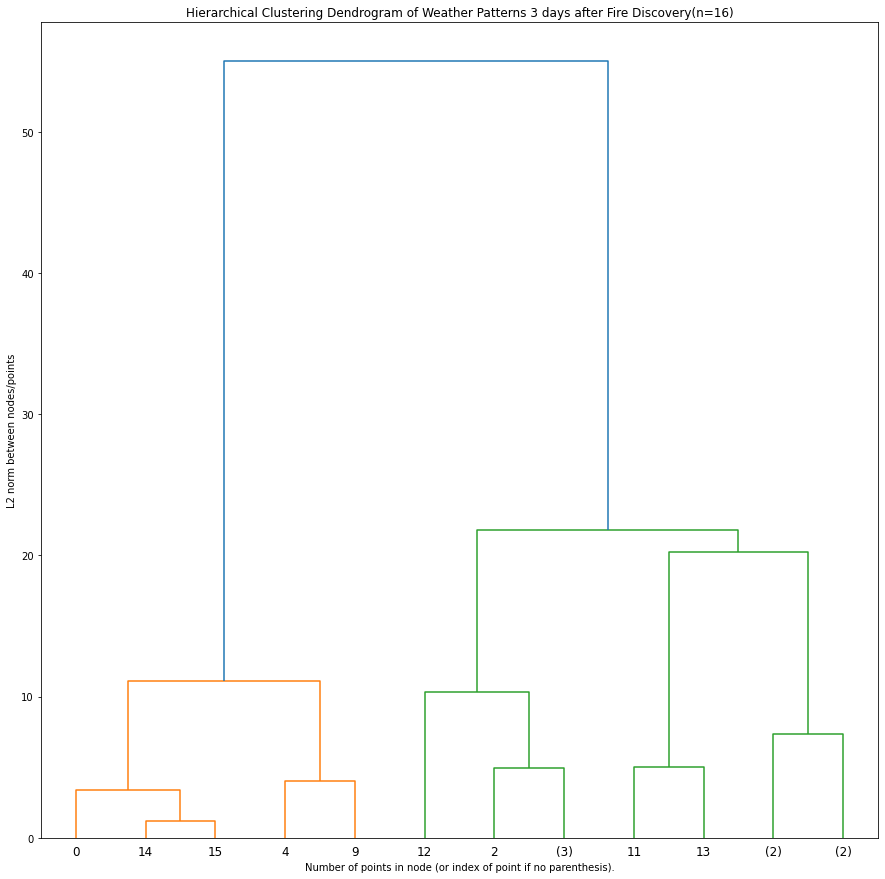

In [149]:
# Dendrogram of Weather Patterns on the day after fire discovery 

plus_3 = list_to_df(plus_3_weather)
size = np.shape(plus_3)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(plus_3)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 3 days after Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

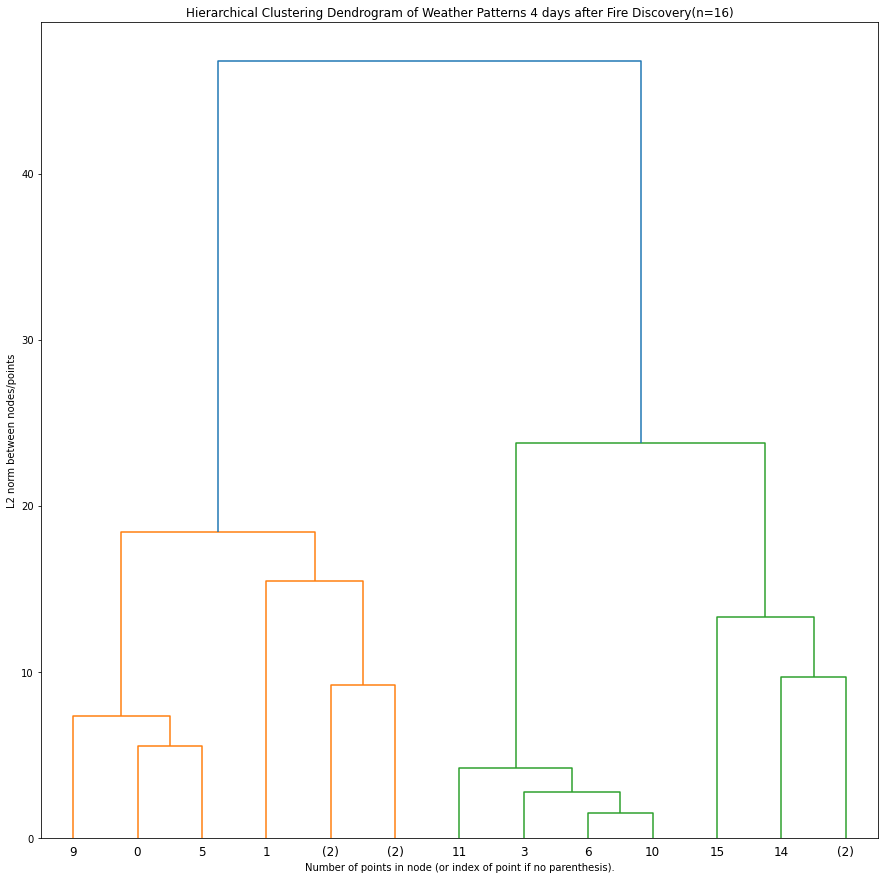

In [150]:
# Dendrogram of Weather Patterns on the day after fire discovery 

plus_4 = list_to_df(plus_4_weather)
size = np.shape(plus_4)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(plus_4)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 4 days after Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

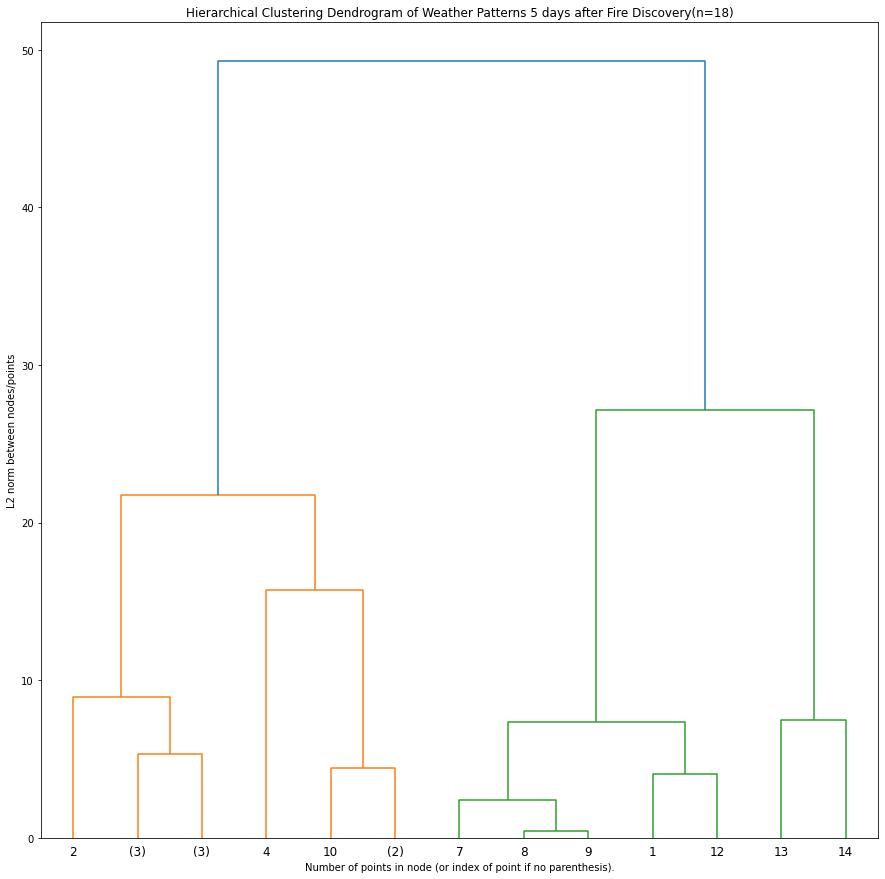

In [153]:
# Dendrogram of Weather Patterns on the day after fire discovery 

plus_5 = list_to_df(plus_5_weather)
size = np.shape(plus_5)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(plus_5)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 5 days after Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

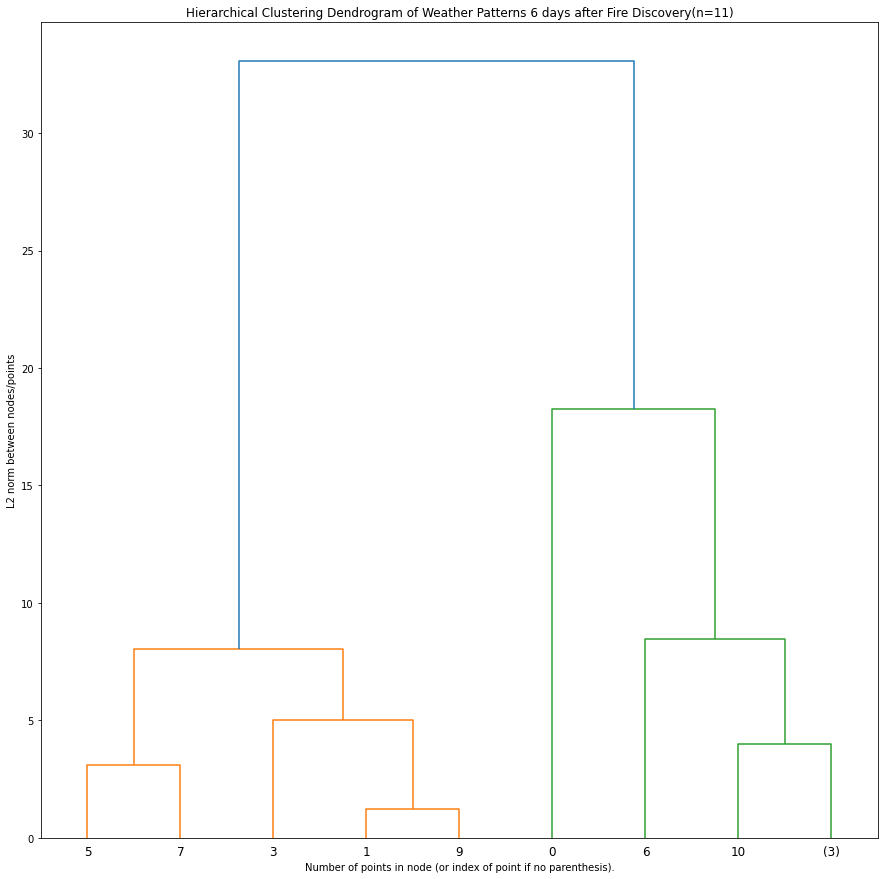

In [152]:
# Dendrogram of Weather Patterns on the day after fire discovery 

plus_6 = list_to_df(plus_6_weather)
size = np.shape(plus_6)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(plus_6)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 6 days after Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()

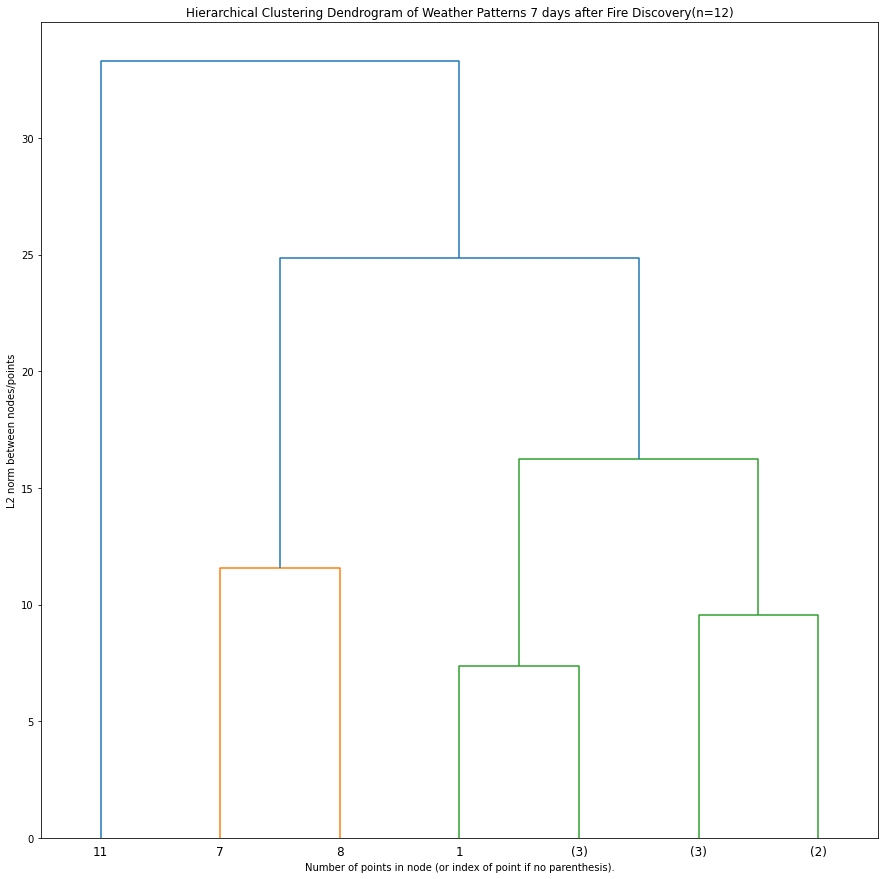

In [154]:
# Dendrogram of Weather Patterns on the day after fire discovery 

plus_7 = list_to_df(plus_7_weather)
size = np.shape(plus_7)[0]

plt.rcParams["figure.figsize"] = (15,15)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(plus_7)
plt.title("Hierarchical Clustering Dendrogram of Weather Patterns 7 days after Fire Discovery(n=%d)" %size)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("L2 norm between nodes/points")
plt.show()